In [151]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import cv2

In [152]:
img = cv2.imread('Emily-In-Paris-gray.png', cv2.IMREAD_GRAYSCALE)
height, width = img.shape
# cv2.imshow('gray', original_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [153]:
def get_neighbor_pixels(image, coord, T):
    x, y = coord
    s_coord, s_value = [], []
    
    for i in range(-T, T+1):
        for j in range(-T, T+1):
            if i == j == 0: continue
            try: 
                if x + i < 0 or y + j < 0: continue
                s = image[x+i][y+j] 
                s_coord.append((x+i, y+j))
                s_value.append(s)
            except IndexError: continue     
    return s_coord, s_value

def weight_f(mean, var, r, s): # option 2
    eps = 1e-6
    return 1 + ((r-mean)*(s-mean))/(var+eps)

def get_weight(r, values):
    n_mean, n_var = np.mean(values), np.var(values)
    weight_neighbor = [weight_f(n_mean, n_var, r, i) for i in values]
    normalized_neighbor = weight_neighbor / np.sum(weight_neighbor)
    return normalized_neighbor

def get_neighbor_matrix(image, T):
    height, width = image.shape
    neighborhood = sparse.lil_matrix((height * width, height * width)) # 337,500 * 337,500
    numbering = 0

    for i in range(height):
        for j in range(width):
            r = img[i][j]
            coords, values = get_neighbor_pixels(img, (i, j), T)
            normalized_neighbor = get_weight(r, values)
            for (x, y), weight in zip(coords, normalized_neighbor):
                neighborhood[numbering, x * width + y] = weight
            numbering += 1
            
    return neighborhood

In [154]:
naver = get_neighbor_matrix(img, 2)

In [155]:
# plt.figure(figsize=(50,50))
# plt.spy(naver, markersize=1)
# plt.show()

In [189]:
scribbles = cv2.imread('Emily-In-Paris-scribbles.png')
h, w, c = scribbles.shape

scribbles_back, scribbles_fore = np.zeros((h * w,)), np.zeros((h * w,))
numbering = 0

for i in range(height):
    for j in range(width):
        if scribbles[i][j][2] == 1: scribbles_back[numbering] = 1
        elif scribbles[i][j][2] == 2: scribbles_fore[numbering] = 1
        numbering += 1

In [190]:
identity_matrix = sparse.identity(height * width)
# i_minus_weight = identity_matrix - naver

In [191]:
# plt.figure(figsize=(50,50))
# plt.spy(i_minus_weight, markersize=1)
# plt.show()

In [192]:
for i in range(naver.shape[0]):
    if scribbles_back[i] == 1 or scribbles_fore[i] == 1:
        naver[i, :] = 0
naver[:10,:10].toarray()

array([[0.00000000e+00, 4.99998000e-01, 4.99998000e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [3.33332111e-01, 0.00000000e+00, 3.33332111e-01, 3.33332111e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [2.49999125e-01, 2.49999125e-01, 0.00000000e+00, 2.49999125e-01,
        2.49999125e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.66666278e-01, 1.66666278e-01, 0.00000000e+00,
        1.66666278e-01, 1.66666278e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.24999781e-01, 1.24999781e-01,
        0.00000000e+00, 1.24999781e-01, 1.24999781e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.24999781e-01,
   

In [193]:
i_minus_weight = identity_matrix - naver

In [194]:
i_minus_weight[:10, :10]

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 44 stored elements in Compressed Sparse Row format>

In [232]:
from scipy.sparse import linalg
import time

st = time.time()
x_back = linalg.lsqr(i_minus_weight, scribbles_back)
print((time.time()-st)/60)

34.46601995229721


In [241]:
st = time.time()
x_fore = linalg.lsqr(i_minus_weight, scribbles_fore)
print((time.time()-st)/60)

28.229283312956493


In [259]:
n = np.stack([x_back[0], x_fore[0]], axis=0)
c = n.argmax(axis=0)
# v = np.reshape(c, (h, w))
n.shape
c

array([0, 0, 0, ..., 1, 1, 1])

In [260]:
sp_m = np.reshape(c, (h, w))

In [261]:
sp_m.shape

(450, 750)

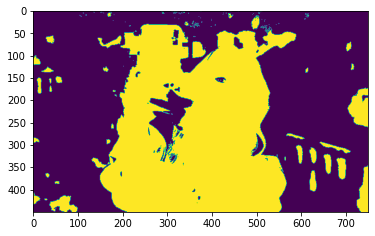

In [262]:
plt.imshow(sp_m)

In [306]:
sp_m

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [373]:
gt = cv2.imread('Emily-In-Paris-gt.png', cv2.COLOR_BGR2RGB)

In [374]:
gt = gt * 255

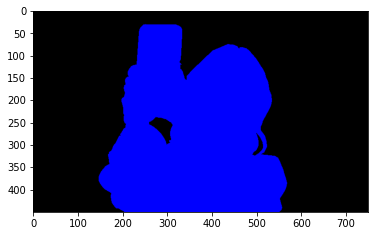

In [375]:
plt.imshow(gt)

In [376]:
sp_m = sp_m * 255

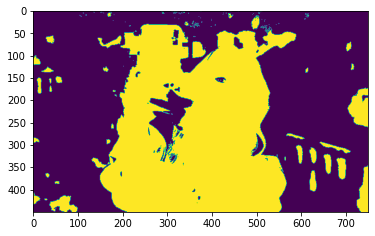

In [377]:
plt.imshow(sp_m)

In [281]:
intersection = np.logical_and(gt, sp_m)

In [282]:
union = np.logical_or(gt, sp_m)

In [283]:
np.where(intersection == 1)

(array([], dtype=int64), array([], dtype=int64))

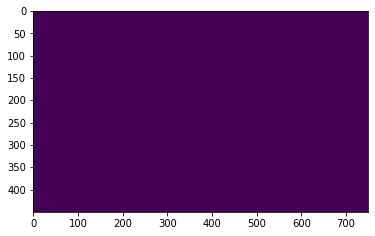

In [284]:
plt.imshow(intersection)

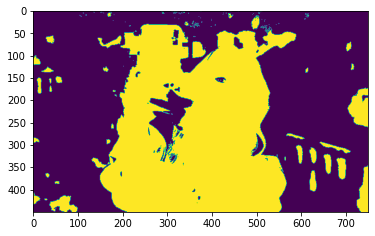

In [285]:
plt.imshow(union)